# Post-Training Quantization of ImageBind model with NNCF

The goal of this tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer quantized model via OpenVINO™ Toolkit. 

The optimization process contains the following steps:
1. Quantize converted OpenVINO model from [notebook](239-image-bind-convert.ipynb) with NNCF.
2. Compare probability matrices between converted and quantized models on input data examples.
3. Compare model size of converted and quantized models.
4. Compare performance of converted and quantized models.

> **NOTE**: you should run [239-image-bind-convert](239-image-bind-convert.ipynb) notebook first to generate OpenVINO IR models that are used for quantization.


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Create and initialize quantization](#Create-and-initialize-quantization)
    - [Prepare datasets](#Prepare-datasets)
- [Compare results for the OpenVINO FP16 model and the quantized model](#Compare-results-for-the-OpenVINO-FP16-model-and-the-quantized-model)
    - [Select inference device](#Select-inference-device)
        - [Compare File Size](#Compare-File-Size)
        - [Compare inference time of the FP16 IR and quantized models](#Compare-inference-time-of-the-FP16-IR-and-quantized-models)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q datasets librosa soundfile "openvino>=2023.1.0" "nncf"

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

repo_dir = Path("ImageBind")

if not repo_dir.exists():
    raise RuntimeError('This notebook should be run after 239-image-bind-convert notebook')

%cd {repo_dir}

/home/ea/work/openvino_notebooks/notebooks/239-image-bind/ImageBind


## Create and initialize quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires a few modifications.

The optimization process contains the following steps:
1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting a quantized model.
3. Serialize the `INT8` model using `openvino.save_model` function.

In [3]:
from pathlib import Path
from imagebind.models.imagebind_model import ModalityType

modalities = [ModalityType.TEXT, ModalityType.VISION, ModalityType.AUDIO]
fp_model_paths = {modality: Path(f"image-bind-{modality}") / f"image-bind-{modality}.xml" for modality in modalities}
int8_model_paths = {modality: Path(f"image-bind-{modality}") / f"image-bind-{modality}_int8.xml" for modality in modalities}

/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


### Prepare datasets
[back to top ⬆️](#Table-of-contents:)


The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions. Dataset is used to quantize image and text models.

In [4]:
import imagebind.data as data
import os
import requests
import tempfile

from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False

def collate_fn(examples, image_column="image_url", text_column="caption"):
    """
    Collates examples into a batch for processing.
    Preprocesses each example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column of the example dictionary.
    Constructs and returns a dictionary representing the collated batch with the following keys:
       - "pixel_values": The pixel values of the preprocessed example.
       - "input_ids": The transformed text data of the preprocessed example.
    """
    assert len(examples) == 1
    example = examples[0]
    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    with tempfile.TemporaryDirectory() as tempdir:
        f_name = os.path.join(tempdir, 'image.jpg')
        try:
            response = requests.get(url, verify=False, timeout=20)
            with open(f_name, "wb") as file:
                file.write(response.content)
            pixel_values = data.load_and_transform_vision_data([f_name], "cpu")
        except Exception:
            print(f"Can't load image from url: {url}")
            return None

    text = data.load_and_transform_text([example[text_column]], "cpu")

    return {
        "pixel_values": pixel_values,
        "input_ids": text
    }

In [5]:
from datasets import load_dataset
import itertools
import torch
from tqdm.notebook import tqdm

def collect_vision_text_data(dataloader, init_steps):
    """
    This function collects vision and text data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant vision and text data.
    Returns a tuple containing the collected vision_data and text_data lists.
    """
    text_data = []
    vision_data = []
    print(f"Fetching {init_steps} for the initialization...")
    counter = 0
    for batch in tqdm(dataloader):
        if counter == init_steps:
            break
        with torch.no_grad():
            if batch:
                counter += 1
                text_data.append(batch["input_ids"].to("cpu"))
                vision_data.append(batch["pixel_values"].to("cpu"))
    return vision_data, text_data

def prepare_vision_text_dataset(opt_init_steps=300):
    """
    Prepares a vision-text dataset for quantization by collecting vision and text data.
    """
    dataset = load_dataset("conceptual_captions", streaming=True)
    train_dataset = dataset["train"].shuffle(seed=0)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    vision_data, text_data = collect_vision_text_data(dataloader, opt_init_steps)
    return vision_data, text_data

The [`ESC-50`](https://github.com/karolpiczak/ESC-50) dataset is used to quantize the audio modality of the ImageBind model.
Dataset is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.
The dataset consists of 5-second-long recordings organized into 50 semantic classes.

In [6]:
import numpy as np
import torchaudio

def collect_audio_data(dataloader, init_steps=300):
    """
    This function collects audio data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing them in a list.
    """
    audio_data = []
    for _, batch in tqdm(zip(range(init_steps), itertools.islice(dataloader, 0, init_steps))):
        with torch.no_grad():
            audio_data.append(batch)
    return audio_data

def prepare_audio_dataset():
    """
    Prepares an "ashraq/esc50" audio dataset for quantization by collecting audio data.
    Collects audio data from the dataloader by calling the `collect_audio_data` function.
    Returns a list containing the collected calibration audio data batches.
    """
    audio_dataset = load_dataset("ashraq/esc50", streaming=True)
    train_dataset = audio_dataset["train"].shuffle(seed=42, buffer_size=1000)

    def collate_fn(examples):
        assert len(examples) == 1
        with tempfile.TemporaryDirectory() as tempdir:
            f_name = os.path.join(tempdir, 'audio.wav')
            audio_data = examples[0]['audio']['array']
            sample_rate = examples[0]['audio']["sampling_rate"]
            audio_data = torch.from_numpy(audio_data).to(torch.float32).unsqueeze(0)
            torchaudio.save(f_name, audio_data, sample_rate)
            return data.load_and_transform_audio_data([f_name], "cpu")

    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    calibration_data = collect_audio_data(dataloader)
    return calibration_data

Create a quantized model from the pre-trained `FP16` model.

In [7]:
vision_data, text_data = prepare_vision_text_dataset()

Fetching 300 for the initialization...


0it [00:00, ?it/s]

Can't load image from url: http://homeklondike.org/wp-content/uploads/2015/06/2-Bright-living-room-in-the-attic1.jpg
Can't load image from url: http://www.lovemeinitaly.com/wp-content/uploads/cache/images/2018/01/4A-e1491723576743/4A-e1491723576743-1964759082.jpg
Can't load image from url: https://i0.wp.com/childphotocompetition.com/wp-content/uploads/2016/02/Agnieszka_He%E2%80%8E_childphotocompetition.jpg
Can't load image from url: https://magankonoski.com/wp-content/uploads/2016/05/MaganKonoskiFineArtWeddingandLifestylePhotographer-25-683x1024.jpg
Can't load image from url: http://www.huahin-home-property.com/wp-content/uploads/2016/11/2immobilier-real-eatate-huahin-maison-a-vendre-condo-for-salerent-The-Autumm-Khao-takibe.jpg
Can't load image from url: http://www.americanclassichomes.com/blog/wp-content/uploads/2015/04/Alki_SB_Kitchen_internet.jpg
Can't load image from url: http://assets.nydailynews.com/polopoly_fs/1.110031.1313943805!/img/httpImage/image.jpg_gen/derivatives/article

In [8]:
import logging
import nncf
import openvino as ov

nncf.set_log_level(logging.ERROR)

core = ov.Core()

def quantize_openvino_model(modality, calibration_data):
    model_path = fp_model_paths[modality]
    if not os.path.exists(model_path):
        raise RuntimeError(f"Model: {model_path} not found. \
                             First run 239-image-bind-convert notebook to convert model to OpenVINO IR.")

    model = core.read_model(model_path)
    quantized_model = nncf.quantize(
        model=model,
        calibration_dataset=calibration_data,
        model_type=nncf.ModelType.TRANSFORMER,
        # remove ignored_scope for nncf>=2.6.0 (PR with fix https://github.com/openvinotoolkit/nncf/pull/1953)
        ignored_scope=nncf.IgnoredScope(types=["ReduceL2"])
    )
    ov.save_model(quantized_model, int8_model_paths[modality])
    return quantized_model

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Quantize ImageBind model for vision modality.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [9]:
if len(vision_data) == 0:
    raise RuntimeError(
        'Calibration dataset is empty. Please check internet connection and try to download images manually from the URLs above.'
    )

vision_dataset = nncf.Dataset(vision_data)
vision_quantized_model = quantize_openvino_model(modality=ModalityType.VISION, calibration_data=vision_dataset)

2023-10-26 13:34:25.166422: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 13:34:25.203294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 13:34:26.097309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Applying Fast Bias correction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  5.54it/s]


Quantize ImageBind model for text modality

In [10]:
text_dataset = nncf.Dataset(text_data)
text_quantized_model = quantize_openvino_model(modality=ModalityType.TEXT, calibration_data=text_dataset)

Applying Fast Bias correction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.06it/s]


Quantize ImageBind model for audio modality

In [11]:
audio_calibration_data = prepare_audio_dataset()
audio_dataset = nncf.Dataset(audio_calibration_data)
audio_quantized_model = quantize_openvino_model(modality=ModalityType.AUDIO, calibration_data=audio_dataset)

Repo card metadata block was not found. Setting CardData to empty.


0it [00:00, ?it/s]

Applying Fast Bias correction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 12.18it/s]


NNCF also supports quantization-aware training, and other algorithms than quantization.
See the [NNCF documentation](https://github.com/openvinotoolkit/nncf/#documentation) in the NNCF repository for more information.

## Compare results for the OpenVINO FP16 model and the quantized model
[back to top ⬆️](#Table-of-contents:)

Compare the probability matrices for `FP16` and `INT8` models.
More details about probability matrix can be found in [notebook](239-image-bind-convert.ipynb).

In [12]:
# Prepare inputs
from imagebind.models.imagebind_model import ModalityType

text_list = ["A car", "A bird", "A dog"]
image_paths = [".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
audio_paths = [".assets/dog_audio.wav", ".assets/bird_audio.wav", ".assets/car_audio.wav"]

inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, "cpu"),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, "cpu"),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, "cpu"),
}

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [13]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

Get embeddings of original models

In [14]:
embeddings = {}
for modality in modalities:
    ov_model = core.compile_model(fp_model_paths[modality], device.value)
    embeddings[modality] = ov_model(inputs[modality])[ov_model.output(0)]

Get embeddings of quantized models

In [15]:
quantized_embeddings = {}
for modality in modalities:
    model = core.compile_model(int8_model_paths[modality], device.value)
    quantized_embeddings[modality] = model(inputs[modality])[model.output(0)]

In [16]:
import matplotlib.pyplot as plt
from scipy.special import softmax

def visualize_prob_matrices(fp_matrix, int_matrix, x_label, y_label):
    fig, ax = plt.subplots(1, 2)
    for i, matrix in enumerate([fp_matrix, int_matrix]):
        ax[i].matshow(matrix, cmap='winter')

        for (k, j), z in np.ndenumerate(matrix):
            ax[i].title.set_text('FP16 probs' if i == 0 else 'INT8 probs')
            ax[i].text(j, k, '{:0.3f}'.format(z), ha='center', va='center')
            ax[i].set_xticks(range(len(x_label)), x_label)
            ax[i].set_yticks(range(len(y_label)), y_label)
    fig.tight_layout()

image_list = [img.split('/')[-1] for img in image_paths]
audio_list = [audio.split('/')[-1] for audio in audio_paths]

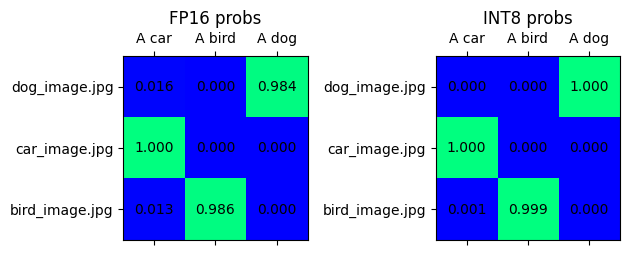

In [17]:
fp_text_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, axis=-1)
int_text_vision_scores = softmax(quantized_embeddings[ModalityType.VISION] @ quantized_embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrices(fp_text_vision_scores, int_text_vision_scores, text_list, image_list)

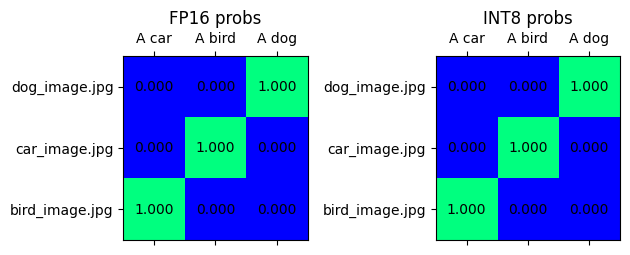

In [18]:
fp_text_audio_scores = softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, axis=-1)
int_text_audio_scores = softmax(quantized_embeddings[ModalityType.AUDIO] @ quantized_embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrices(fp_text_audio_scores, int_text_audio_scores, text_list, image_list)

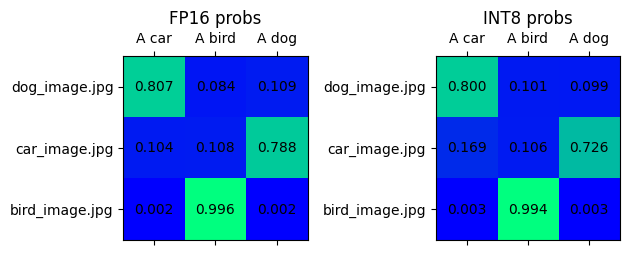

In [19]:
fp_audio_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, axis=-1)
int_audio_vision_scores = softmax(quantized_embeddings[ModalityType.VISION] @ quantized_embeddings[ModalityType.AUDIO].T, axis=-1)

visualize_prob_matrices(fp_audio_vision_scores, int_audio_vision_scores, text_list, image_list)

#### Compare File Size
[back to top ⬆️](#Table-of-contents:)


In [20]:
def calculate_compression_rate(modality):
    fp16_ir_model_size = Path(fp_model_paths[modality]).with_suffix(".bin").stat().st_size / 1024
    quantized_model_size = Path(int8_model_paths[modality]).with_suffix(".bin").stat().st_size / 1024
    print(f'Modality: {modality}')
    print(f"    * FP16 IR model size: {fp16_ir_model_size:.2f} KB")
    print(f"    * INT8 model size: {quantized_model_size:.2f} KB")
    print(f"    * Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

In [21]:
for modality in modalities:
    calculate_compression_rate(modality)

Modality: text
    * FP16 IR model size: 691481.77 KB
    * INT8 model size: 347007.35 KB
    * Model compression rate: 1.993
Modality: vision
    * FP16 IR model size: 1235995.26 KB
    * INT8 model size: 620133.72 KB
    * Model compression rate: 1.993
Modality: audio
    * FP16 IR model size: 168429.22 KB
    * INT8 model size: 84818.78 KB
    * Model compression rate: 1.986


#### Compare inference time of the FP16 IR and quantized models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [22]:
import time

def calculate_inference_time(model_path, calibration_data):
    model = core.compile_model(model_path)
    output_layer = model.output(0)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[output_layer]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

Vision model

In [23]:
fp16_latency = calculate_inference_time(fp_model_paths[ModalityType.VISION], vision_data)
int8_latency = calculate_inference_time(int8_model_paths[ModalityType.VISION], vision_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 2.040


Text model

In [24]:
fp16_latency = calculate_inference_time(fp_model_paths[ModalityType.TEXT], text_data)
int8_latency = calculate_inference_time(int8_model_paths[ModalityType.TEXT], text_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 1.404


Audio model

In [25]:
fp16_latency = calculate_inference_time(fp_model_paths[ModalityType.AUDIO], audio_calibration_data)
int8_latency = calculate_inference_time(int8_model_paths[ModalityType.AUDIO], audio_calibration_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 5.713
